# FASE 2: Voorspellen elektrisch verbruik warmtepomp

* kWh per tijdbasis 15m
* Household 1 gebruikt voor data (JVR)
* datetime features
   * stookseizoen
   * dag
   * uur

In [1]:
import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import datetime as dt

from scripts import weather_data_preprocess as wdp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Geef een enkele dag weer in een grafiek
def plot_day(data, day: dt.datetime):
    plt.figure(figsize=(10, 6))
    ax1 = plt.subplot()
    plt.xticks(rotation=90)
    ax2 = ax1.twinx()
    ax1.plot(data['datetime'], data['consumption_kWh'], label='Consumption (kWh)', color='g')
    ax1.set_xlabel('Hour of the day')
    ax1.set_ylabel('Energy (kWh)', color='black')
    ax1.legend(loc='upper left')
    ax2.plot(data['datetime'], data['temp'], label='Temperature (°C)', color='b')
    ax2.set_ylabel('Temperature (°C)', color='black')
    ax2.legend(loc='upper right')
    plt.title(f'Energy on {day}')
    plt.grid(True)
    plt.show()

In [3]:
# Filter gegevens op een lijst met substrings
def filter_data(df, column_name, substrings):
    return df[df[column_name].str.contains('|'.join(substrings))]

## Data-analyse
### Inlezen en voorbereiden van data

In [4]:
# Open de datasets
df_heat = pd.read_csv('data/raw/household_1_heat_pump_consumption_warmtepomp from 2024-03-01.csv')
df_control = pd.read_csv('data/raw/household_1_heat_pump_control_consumption_warmtepomp from 2024-03-01.csv')
df_heat.tail(10)

,_time,heat_consumption
28536,2025-01-17 11:45:00+01:00,9445.741
28537,2025-01-17 12:00:00+01:00,9446.057
28538,2025-01-17 12:15:00+01:00,9446.362
28539,2025-01-17 12:30:00+01:00,9446.652
28540,2025-01-17 12:45:00+01:00,9446.932
28541,2025-01-17 13:00:00+01:00,9447.173
28542,2025-01-17 13:15:00+01:00,9447.402
28543,2025-01-17 13:30:00+01:00,9447.618
28544,2025-01-17 13:45:00+01:00,9447.814
28545,2025-01-17 13:58:05.169652485+01:00,9447.985


In [5]:
# Samenvoegen van de kWh datasets
df_heat = pd.merge(df_heat, df_control, on='_time')
print(f"Dataset size: {df_heat.size}")
df_heat.tail()

Dataset size: 85635


,_time,heat_consumption,control_consumption
28540,2025-01-17 12:45:00+01:00,9446.932,1287.348
28541,2025-01-17 13:00:00+01:00,9447.173,1287.365
28542,2025-01-17 13:15:00+01:00,9447.402,1287.379
28543,2025-01-17 13:30:00+01:00,9447.618,1287.392
28544,2025-01-17 13:45:00+01:00,9447.814,1287.403


In [6]:
# Consumptie kolommen optellen en samenvoegen
df_heat['consumption'] = df_heat['heat_consumption'] + df_heat['control_consumption']
df_heat = df_heat.drop(columns=['heat_consumption', 'control_consumption'])
df_heat.tail()

,_time,consumption
28540,2025-01-17 12:45:00+01:00,10734.280
28541,2025-01-17 13:00:00+01:00,10734.538
28542,2025-01-17 13:15:00+01:00,10734.781
28543,2025-01-17 13:30:00+01:00,10735.010
28544,2025-01-17 13:45:00+01:00,10735.217


In [7]:
# Verwerken van de ontbrekende waarden

#optie 1: Verwijder de rijen met ontbrekende waarden
#df_heat = df_heat.dropna()

#optie 2: Vul de ontbrekende waarden in met forward fill
df_heat = df_heat.fillna(method='ffill')

print(f"Dataset size: {df_heat.size}")
df_heat.tail()

Dataset size: 57090


/var/folders/yg/5hgw5_z931sd5sx564slbskh0000gq/T/ipykernel_35778/3362158841.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_heat = df_heat.fillna(method='ffill')


,_time,consumption
28540,2025-01-17 12:45:00+01:00,10734.280
28541,2025-01-17 13:00:00+01:00,10734.538
28542,2025-01-17 13:15:00+01:00,10734.781
28543,2025-01-17 13:30:00+01:00,10735.010
28544,2025-01-17 13:45:00+01:00,10735.217


In [ ]:
# Bereken kWh voor elke 15 min
df_heat['consumption_kWh'] = (df_heat['consumption'] - df_heat['consumption'].shift(1))
df_heat.drop(['consumption'], axis=1, inplace=True)
df_heat = df_heat.dropna(
print(f"Dataset size: {df_heat.size}")
df_heat.head()

Dataset size: 57088


,_time,consumption_kWh
1,2024-03-14 08:15:00+01:00,0.048
2,2024-03-14 08:45:00+01:00,0.145
3,2024-03-14 09:00:00+01:00,0.045
4,2024-03-14 09:15:00+01:00,0.044
5,2024-03-14 09:30:00+01:00,0.044


In [9]:
# Tijdskolom aanpassen
df_heat['datetime'] = (df_heat['_time'].str.replace(' ', 'T'))
df_heat['datetime'] = (df_heat['datetime'].str.replace('+01:00', ''))
df_heat['datetime'] = (df_heat['datetime'].str.replace('+02:00', ''))
df_heat['datetime'] = pd.to_datetime(df_heat['datetime'], errors='coerce')
df_heat.drop(['_time'], axis=1, inplace=True)
print(df_heat['datetime'].isnull().sum())
print(f"Dataset size: {df_heat.size}")
df_heat.tail()

0
Dataset size: 57088


,consumption_kWh,datetime
28540,0.303,2025-01-17 12:45:00
28541,0.258,2025-01-17 13:00:00
28542,0.243,2025-01-17 13:15:00
28543,0.229,2025-01-17 13:30:00
28544,0.207,2025-01-17 13:45:00


In [10]:
print(f"Dataset size: {df_heat.size}")
df_heat.describe()

Dataset size: 57088


,consumption_kWh,datetime
count,28544.000000,28544
mean,0.056468,2024-08-16 18:45:43.133408256
min,0.000000,2024-03-14 08:15:00
25%,0.001000,2024-06-01 09:11:15
50%,0.004000,2024-08-14 18:22:30
75%,0.085000,2024-11-04 05:48:45
max,12.102000,2025-01-17 13:45:00
std,0.130204,NaN


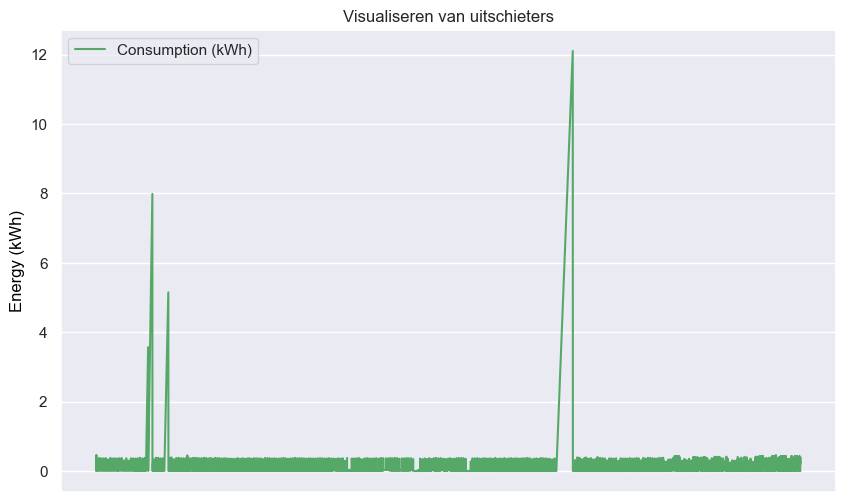

In [11]:
# Visualiseren van de uitschieters
plt.figure(figsize=(10, 6))
ax1 = plt.subplot()
plt.xticks(rotation=90)
ax1.plot(df_heat['datetime'], df_heat['consumption_kWh'], label='Consumption (kWh)', color='g')
ax1.set_ylabel('Energy (kWh)', color='black')
ax1.legend(loc='upper left')
plt.xticks([])  # Removes the x-axis ticks
ax1.set_xticklabels([]) # Removes the x-axis labels
plt.title(f'Visualiseren van uitschieters')
plt.grid(True)
plt.show()

In [12]:
# Verwijder de uitschieters (dit zijn waarschijnlijk fouten als gevolg van ontbrekende gegevens)
threshold = 3
z_scores = np.abs((df_heat['consumption_kWh'] - df_heat['consumption_kWh'].mean()) / df_heat['consumption_kWh'].std())
df_heat = df_heat[z_scores < threshold]
print(f"Dataset size: {df_heat.size}")
df_heat.describe()

Dataset size: 57072


,consumption_kWh,datetime
count,28536.000000,28536
mean,0.055411,2024-08-16 19:14:47.226661120
min,0.000000,2024-03-14 08:15:00
25%,0.001000,2024-06-01 10:11:15
50%,0.004000,2024-08-14 18:52:30
75%,0.084000,2024-11-04 06:03:45
max,0.444000,2025-01-17 13:45:00
std,0.091146,NaN


In [13]:
df_heat.tail(10)

,consumption_kWh,datetime
28535,0.398,2025-01-17 11:30:00
28536,0.357,2025-01-17 11:45:00
28537,0.339,2025-01-17 12:00:00
28538,0.328,2025-01-17 12:15:00
28539,0.312,2025-01-17 12:30:00
28540,0.303,2025-01-17 12:45:00
28541,0.258,2025-01-17 13:00:00
28542,0.243,2025-01-17 13:15:00
28543,0.229,2025-01-17 13:30:00
28544,0.207,2025-01-17 13:45:00


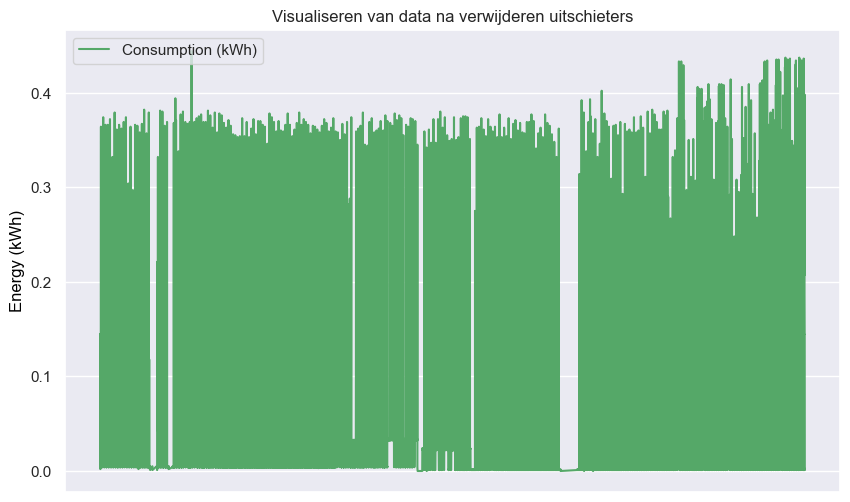

In [14]:
# Visualiseren van de data waarbij de uitschieters zijn verwijderd
plt.figure(figsize=(10, 6))
ax1 = plt.subplot()
plt.xticks(rotation=90)
ax1.plot(df_heat['datetime'], df_heat['consumption_kWh'], label='Consumption (kWh)', color='g')
ax1.set_ylabel('Energy (kWh)', color='black')
ax1.legend(loc='upper left')
plt.xticks([])  # Removes the x-axis ticks
ax1.set_xticklabels([]) # Removes the x-axis labels
plt.title(f'Visualiseren van data na verwijderen uitschieters')
plt.grid(True)
plt.show()

In [15]:
print(df_heat['datetime'].dtype)


datetime64[ns]


In [16]:

df_heat_test = df_heat[df_heat['datetime'].dt.year == 2025]
df_heat = df_heat[df_heat['datetime'].dt.year == 2024]


In [17]:
# Ruwe weersdata info
weather_train_data_ingelmunster = [
    'Ingelmunster 2024-01-01 to 2024-01-31.csv',
    'Ingelmunster 2024-02-01 to 2024-02-29.csv',
    'Ingelmunster 2024-03-01 to 2024-03-31.csv',
    'Ingelmunster 2024-04-01 to 2024-04-30.csv',
    'Ingelmunster 2024-05-01 to 2024-05-31.csv',
    'Ingelmunster 2024-06-01 to 2024-06-30.csv',
    'Ingelmunster 2024-07-01 to 2024-07-31.csv',
    'Ingelmunster 2024-08-01 to 2024-08-31.csv',
    'Ingelmunster 2024-09-01 to 2024-09-30.csv',
    'Ingelmunster 2024-10-01 to 2024-10-31.csv',
    'Ingelmunster 2024-11-01 to 2024-11-30.csv',
    'Ingelmunster 2024-12-01 to 2024-12-31.csv'
]
weather_test_data_ingelmunster = [
    'Ingelmunster 2025-01-01 to 2025-01-31.csv',
]
ingelmunster_location = [50.920699369528734, 3.2532075343447575]



In [18]:
# Interpoleren van de weergegevens
processor = wdp.WeatherDataPreprocess()
df_weather_ingelmunster = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
df_weather_test_ingelmunster = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
for file in range(len(weather_train_data_ingelmunster)):
    print(f'Processing {weather_train_data_ingelmunster[file]}')
    df_weather_ingelmunster = pd.concat([df_weather_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_train_data_ingelmunster[file])])
for file in range(len(weather_test_data_ingelmunster)):
    print(f'Processing {weather_test_data_ingelmunster[file]}')
    df_weather_test_ingelmunster = pd.concat([df_weather_test_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_test_data_ingelmunster[file])])

Processing Ingelmunster 2024-01-01 to 2024-01-31.csv
Processing Ingelmunster 2024-02-01 to 2024-02-29.csv
Processing Ingelmunster 2024-03-01 to 2024-03-31.csv
Processing Ingelmunster 2024-04-01 to 2024-04-30.csv


/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()
/var/folders/yg/5hgw5_z931sd5sx564slbskh0000gq/T/ipykernel_35778/239290881.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_weather_ingelmunster = pd.concat([df_weather_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_train_data_ingelmunster[file])])
/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated a

Processing Ingelmunster 2024-05-01 to 2024-05-31.csv
Processing Ingelmunster 2024-06-01 to 2024-06-30.csv
Processing Ingelmunster 2024-07-01 to 2024-07-31.csv
Processing Ingelmunster 2024-08-01 to 2024-08-31.csv


/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()
/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()
/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()
/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please

Processing Ingelmunster 2024-09-01 to 2024-09-30.csv
Processing Ingelmunster 2024-10-01 to 2024-10-31.csv
Processing Ingelmunster 2024-11-01 to 2024-11-30.csv
Processing Ingelmunster 2024-12-01 to 2024-12-31.csv


/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()
/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()
/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()
/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please

Processing Ingelmunster 2025-01-01 to 2025-01-31.csv


/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()
/var/folders/yg/5hgw5_z931sd5sx564slbskh0000gq/T/ipykernel_35778/239290881.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_weather_test_ingelmunster = pd.concat([df_weather_test_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_test_data_ingelmunster[file])])


In [19]:
# Verwijderen van de kolommen die niet nodig zijn
df_weather_ingelmunster.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)
df_weather_test_ingelmunster.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)

In [20]:
# Datasets samenvoegen
df = pd.merge(df_heat, df_weather_ingelmunster, on='datetime')
df_test = pd.merge(df_heat_test, df_weather_test_ingelmunster, on='datetime')
# Verwijderen van de kolommen die niet nodig zijn
print(f"Dataset size: {df.size}, test size: {df_test.size}")
df.head()

Dataset size: 215344, test size: 12728


,consumption_kWh,datetime,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation
0,0.048,2024-03-14 08:15:00,8.325,54.475,0.325,0.5,-1.054120,0.330412
1,0.145,2024-03-14 08:45:00,9.175,46.225,0.575,1.5,-0.935324,0.399732
2,0.045,2024-03-14 09:00:00,9.600,42.100,0.700,2.0,-0.873267,0.432229
3,0.044,2024-03-14 09:15:00,10.000,48.875,0.900,2.5,-0.809274,0.463056
4,0.044,2024-03-14 09:30:00,10.400,55.650,1.100,3.0,-0.743247,0.492032


In [21]:
df.tail()

,consumption_kWh,datetime,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation
26913,0.001,2024-12-31 22:45:00,7.35,96.4,0.0,0.0,2.606430,-1.035781
26914,0.001,2024-12-31 23:00:00,7.60,96.4,0.0,0.0,2.720394,-1.054756
26915,0.001,2024-12-31 23:15:00,7.70,96.4,0.0,0.0,2.840396,-1.069327
26916,0.001,2024-12-31 23:30:00,7.80,96.4,0.0,0.0,2.965172,-1.079077
26917,0.137,2024-12-31 23:45:00,7.90,96.4,0.0,0.0,3.092942,-1.083698


### Interpretatie van de data, patronen proberen te vinden in de data

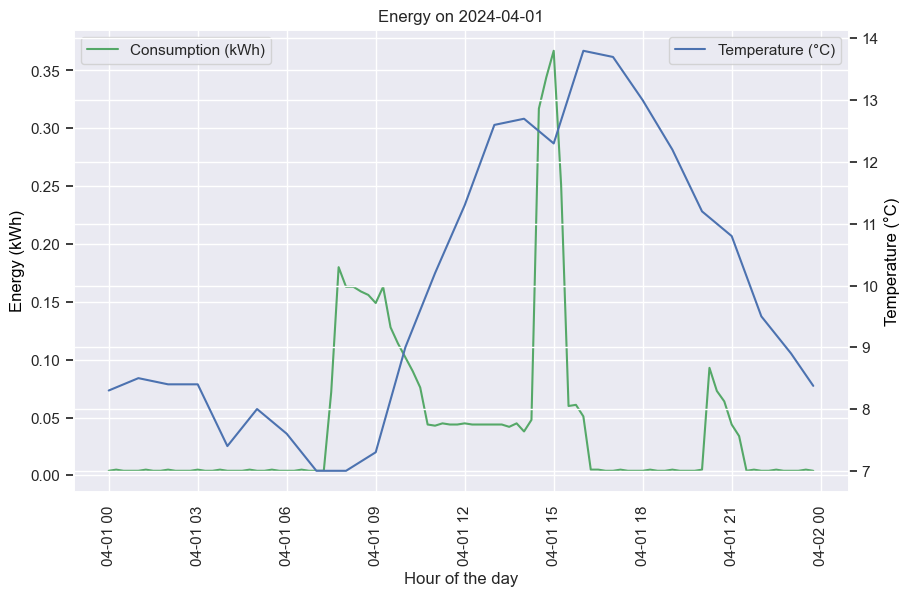

In [22]:
# Toon het dagverloop van het energieverbruik en temperatuur in de 
# lente
filtered_df = df.where(df['datetime'].dt.date == dt.date(2024, 4, 1))
plot_day(filtered_df, '2024-04-01')

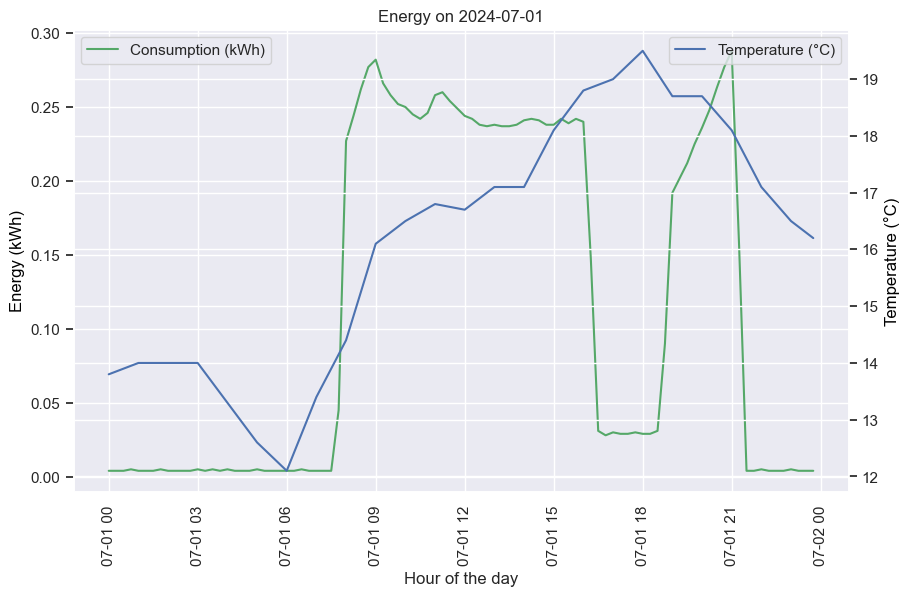

In [23]:
# Toon het dagverloop van het energieverbruik en temperatuur in de 
# zomer
filtered_df = df.where(df['datetime'].dt.date == dt.date(2024, 7, 1))
plot_day(filtered_df, '2024-07-01')

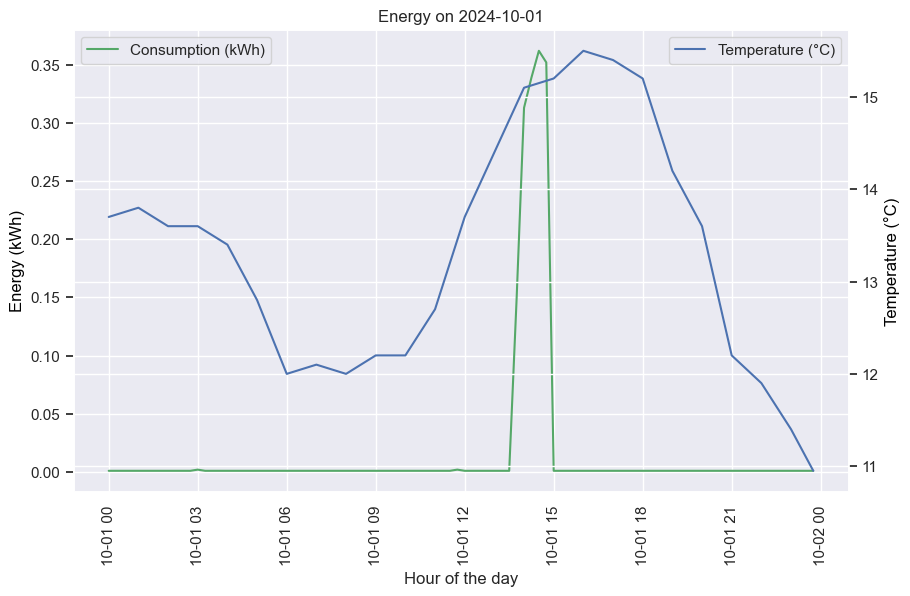

In [24]:
# Toon het dagverloop van het energieverbruik en temperatuur in de 
# herfst
filtered_df = df.where(df['datetime'].dt.date == dt.date(2024, 10, 1))
plot_day(filtered_df, '2024-10-01')

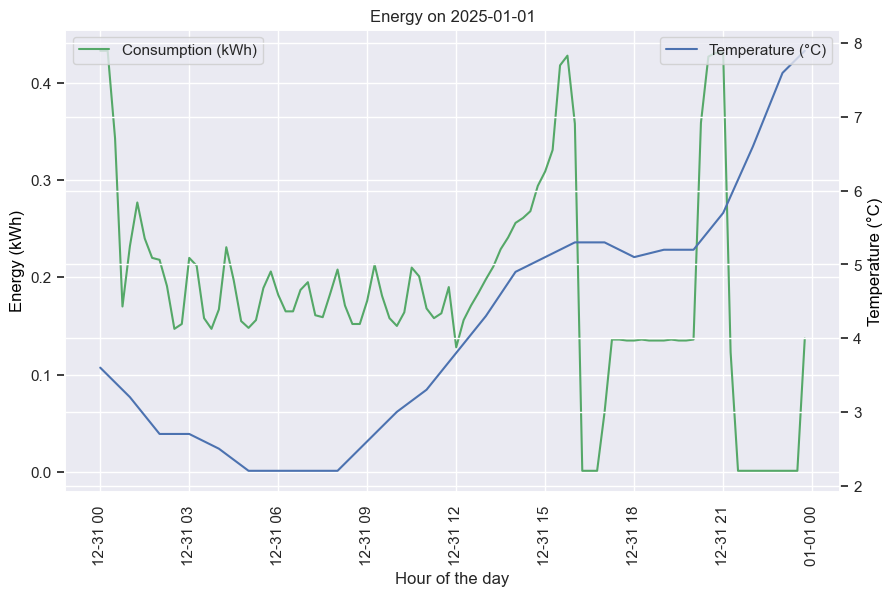

In [25]:
# Toon het dagverloop van het energieverbruik en temperatuur in de 
# winter
filtered_df = df.where(df['datetime'].dt.date == dt.date(2024, 12, 31))
plot_day(filtered_df, '2025-01-01')

### Bewerking datetime en verwijderen van onnodige kolommen

In [26]:
# Geef de dag van het jaar, de dag van de week en de tijd van de dag weer als een sinus- en cosinusgolf
# Dag van het jaar extraheren
df['day_of_year'] = df['datetime'].dt.dayofyear
df_test['day_of_year'] = df_test['datetime'].dt.dayofyear
# Dag van de week extraheren
df['day_of_week'] = df['datetime'].dt.dayofweek
df_test['day_of_week'] = df_test['datetime'].dt.dayofweek
# Uur van de dag extraheren
df['time_of_day'] = df['datetime'].dt.hour
df_test['time_of_day'] = df_test['datetime'].dt.hour
# Bereken sinus- en cosinuswaarden voor day_of_year
df['day_of_year_sine'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cosine'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df_test['day_of_year_sine'] = np.sin(2 * np.pi * df_test['day_of_year'] / 365)
df_test['day_of_year_cosine'] = np.cos(2 * np.pi * df_test['day_of_year'] / 365)
# Bereken sinus- en cosinuswaarden voor day_of_week
df['day_of_week_sine'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cosine'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df_test['day_of_week_sine'] = np.sin(2 * np.pi * df_test['day_of_week'] / 7)
df_test['day_of_week_cosine'] = np.cos(2 * np.pi * df_test['day_of_week'] / 7)
# Bereken sinus- en cosinuswaarden voor hour_of_day
df['hour_of_day_sine'] = np.sin(2 * np.pi * df['time_of_day'] / 24)
df['hour_of_day_cosine'] = np.cos(2 * np.pi * df['time_of_day'] / 24)
df_test['hour_of_day_sine'] = np.sin(2 * np.pi * df_test['time_of_day'] / 24)
df_test['hour_of_day_cosine'] = np.cos(2 * np.pi * df_test['time_of_day'] / 24)


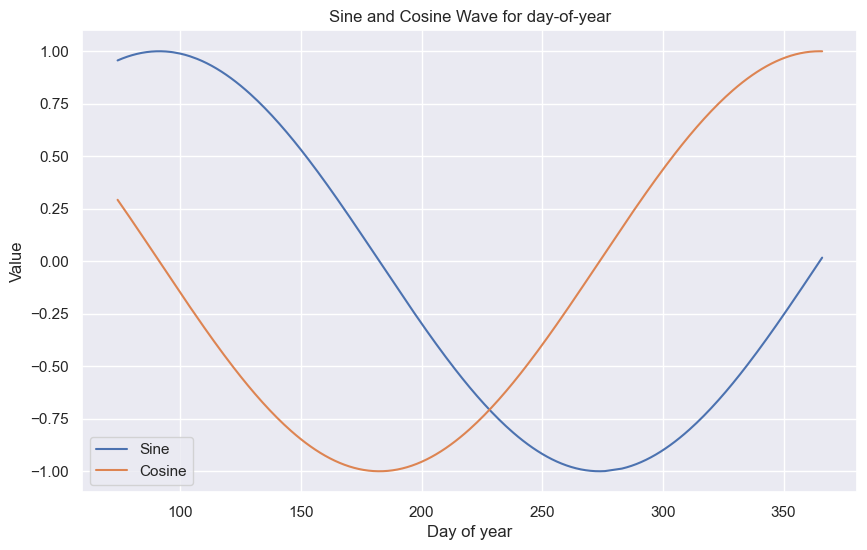

In [27]:
# day_of_year omvorming weergeven
df_single_year = df[df['datetime'].dt.year == 2024]
plt.figure(figsize=(10, 6))
plt.plot(df_single_year['day_of_year'], df_single_year['day_of_year_sine'], label='Sine')
plt.plot(df_single_year['day_of_year'], df_single_year['day_of_year_cosine'], label='Cosine')
plt.xlabel('Day of year')
plt.ylabel('Value')
plt.title('Sine and Cosine Wave for day-of-year')
plt.legend()
plt.grid(True)
plt.show()

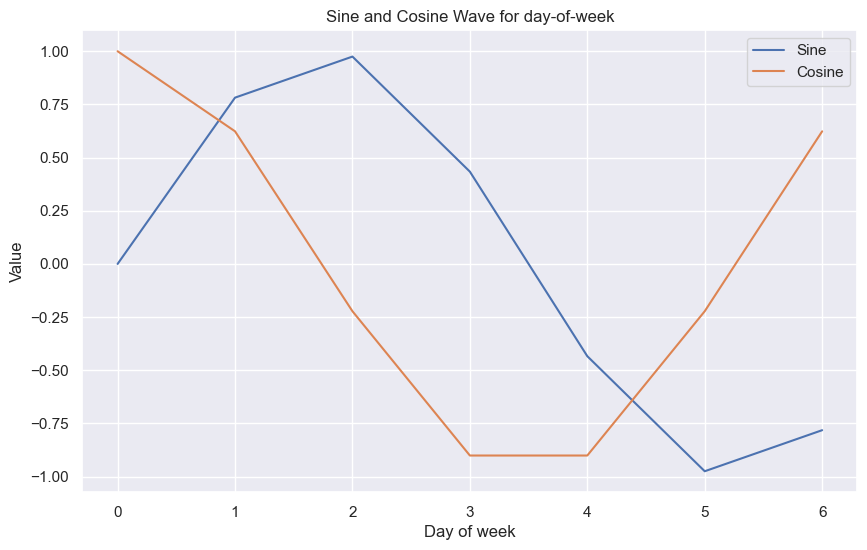

In [28]:
# day_of_week omvorming weergeven
df_single_month = df[df['datetime'].dt.day_of_year.isin([176, 177, 178, 179, 180, 181, 182])]
plt.figure(figsize=(10, 6))
plt.plot(df_single_month['day_of_week'], df_single_month['day_of_week_sine'], label='Sine')
plt.plot(df_single_month['day_of_week'], df_single_month['day_of_week_cosine'], label='Cosine')
plt.xlabel('Day of week')
plt.ylabel('Value')
plt.title('Sine and Cosine Wave for day-of-week')
plt.legend()
plt.grid(True)
plt.show()

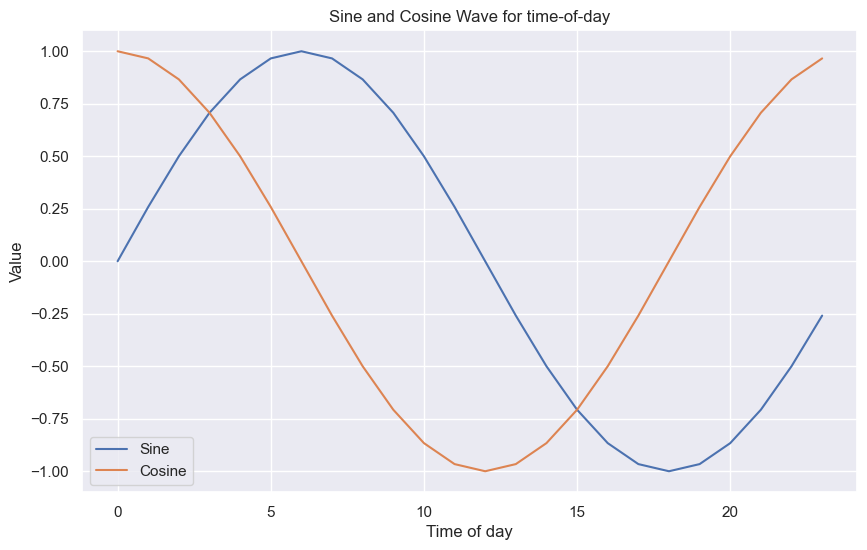

In [29]:
# hour_of_day omvorming weergeven 
df_single_day = df[df['datetime'].dt.day_of_year == 170]
plt.figure(figsize=(10, 6))
plt.plot(df_single_day['time_of_day'], df_single_day['hour_of_day_sine'], label='Sine')
plt.plot(df_single_day['time_of_day'], df_single_day['hour_of_day_cosine'], label='Cosine')
plt.xlabel('Time of day')
plt.ylabel('Value')
plt.title('Sine and Cosine Wave for time-of-day')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Verwijderen van overbodige kolommen
df.drop(columns=['datetime', 'day_of_year', 'day_of_week', 'time_of_day'], inplace=True)
df_test.drop(columns=['day_of_year', 'day_of_week', 'time_of_day'], inplace=True)

Text(0.5, 1.0, 'Correlatiematrix')

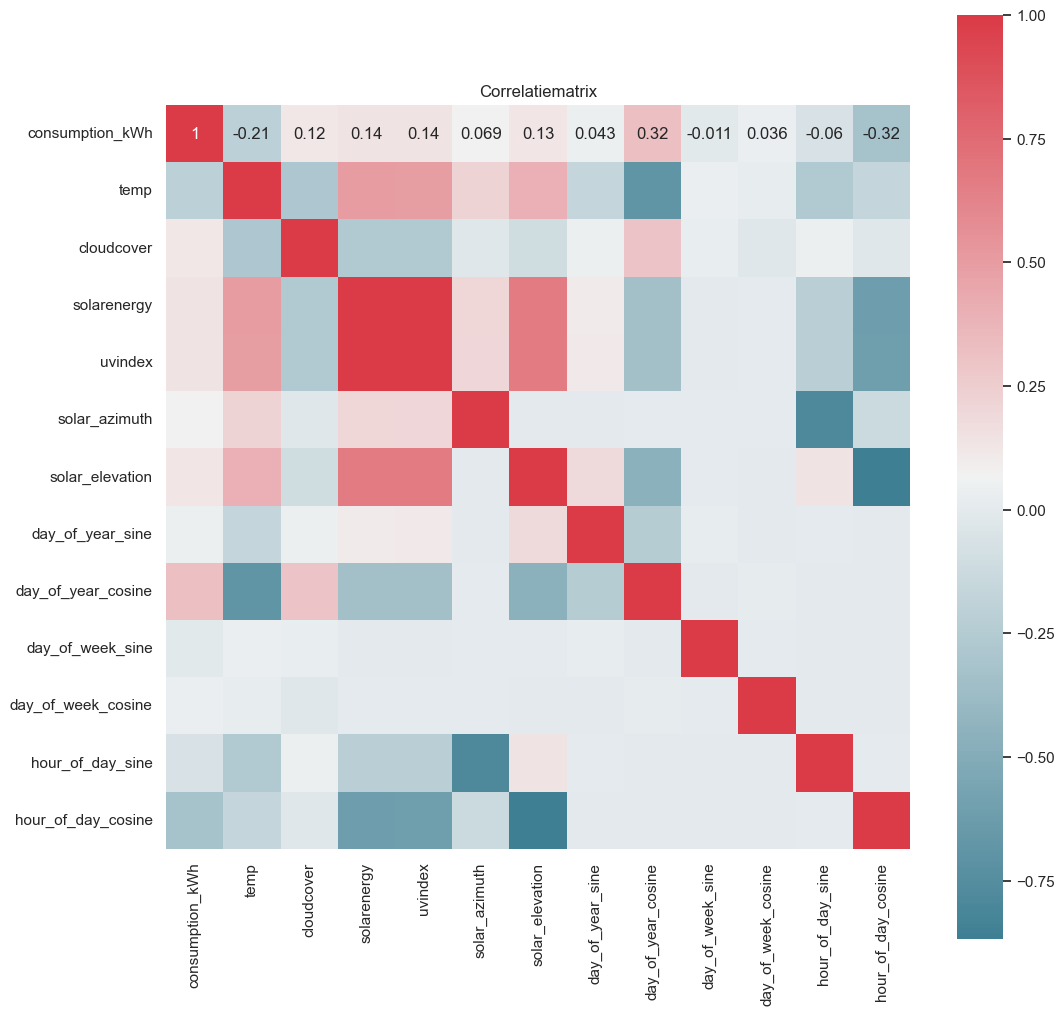

In [31]:
# Plotten van een heatmap om de correlatie tussen de features te visualiseren
f, ax = plt.subplots(figsize=(12, 12))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, annot=True)
plt.title("Correlatiematrix")

## Pre-processing van de data

In [32]:
# Splits de dataset in een trainings- en testset
y = df['consumption_kWh']
X = df.drop(['consumption_kWh'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# De gegevens schalen, aangezien we de outliers hebben verwijderd, kunnen we de MinMaxScaler gebruiken
scaler_consumption = MinMaxScaler()
scaler_consumption.fit(X_train)
X_train = scaler_consumption.transform(X_train)
X_test = scaler_consumption.transform(X_test)

## Training

In [34]:
# Verschillende hyperparameters uitproberen voor de Random Forest Regressor
estimators = [10, 50, 100, 150]
rf_depths = [2, 10, 20, 35, 40, 50]

In [35]:
# Trainen van elke combinatie van hyperparameters en opslaan van de resultaten van het beste model voor consumptie
best_score_consumption = 0
best_model_consumption = None
for estimator in estimators:
    for depth in rf_depths:
        rf_model = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
        rf_model.fit(X_train, y_train)
        score = rf_model.score(X_test, y_test)
        if score > best_score_consumption:
            best_score_consumption = score
            best_model_consumption = rf_model
            # Save the model
            print(f"New best model found with estimators: {estimator}, depth: {depth}, and score: {score}")
            with open('models/wp_ML.pkl', 'wb') as file:
                pickle.dump(rf_model, file)

New best model found with estimators: 10, depth: 2, and score: 0.32785164835847036
New best model found with estimators: 10, depth: 10, and score: 0.7864950434889206
New best model found with estimators: 10, depth: 20, and score: 0.8412500505264189
New best model found with estimators: 10, depth: 35, and score: 0.8487880188503567
New best model found with estimators: 50, depth: 20, and score: 0.8558794332356336
New best model found with estimators: 50, depth: 35, and score: 0.8560661482119635
New best model found with estimators: 50, depth: 50, and score: 0.8570065744200082
New best model found with estimators: 100, depth: 50, and score: 0.8574012645415562
New best model found with estimators: 150, depth: 35, and score: 0.8601098810526489


## Testen

In [36]:
# Beste model inladen
with open('models/wp_ML.pkl', 'rb') as file:
    best_model_consumption = pickle.load(file)

In [37]:
# Validatiegegevens voorbereiden
df_actual_value = df_test[['datetime', 'consumption_kWh']]
df_test.drop(columns=['consumption_kWh', 'datetime'], inplace=True)

In [38]:
# Voorspellingen doen
df_consumption_pred = best_model_consumption.predict(scaler_consumption.transform(df_test))

In [39]:
# Scoor de model op basis van de validatiegegevens
score_consumption = best_model_consumption.score(scaler_consumption.transform(df_test), df_actual_value['consumption_kWh'])
print(f"Score consumption: {score_consumption}")

# Bij optie 1: R2-score = 0,2966


Score consumption: 0.2940258534003688


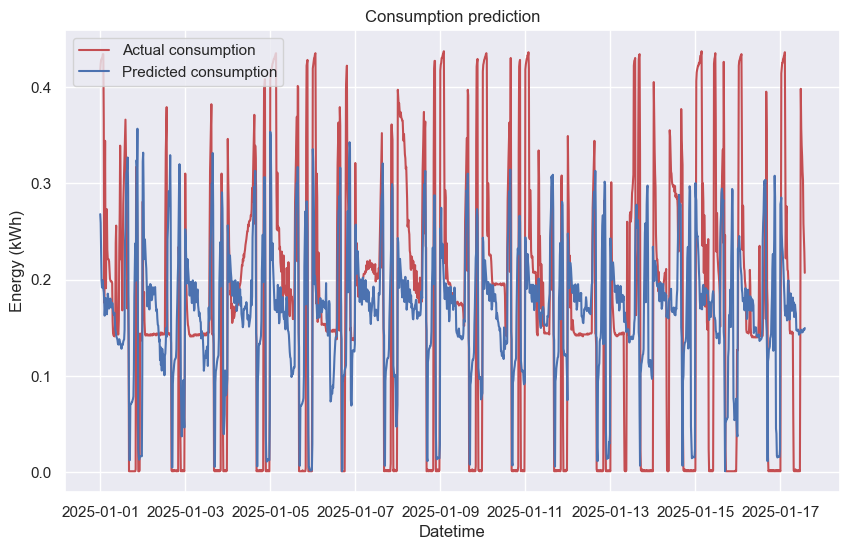

In [40]:
# Visualiseer de verbruiksvoorspellingen
plt.figure(figsize=(10, 6))
plt.plot(df_actual_value['datetime'], df_actual_value['consumption_kWh'], label='Actual consumption', color='r')
plt.plot(df_actual_value['datetime'], df_consumption_pred, label='Predicted consumption', color='b')
plt.xlabel('Datetime')
plt.ylabel('Energy (kWh)')
plt.title('Consumption prediction')
plt.legend()
plt.grid(True)
plt.show()